In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

import torch
import pytorch_lightning as pl


import dataset
import neural_network
import config as cfg

## Parameters

In [2]:
CLASSES = dataset.metadata.get_classes(cfg.paths.LABELS_CSV["train"])  
CLASSES, CLASSES.size

(array(['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC'], dtype='<U5'), 7)

In [3]:
IMG_CHANNELS, IMG_HEIGHT, IMG_WIDTH = dataset.metadata.get_image_dimensions(cfg.paths.IMG_DIR["train"])
IMG_CHANNELS, IMG_HEIGHT, IMG_WIDTH

(3, 450, 600)

## Loading Checkpoint

In [4]:
SEED = 1
pl.seed_everything(SEED, workers=True)

Global seed set to 1


1

In [5]:
data_module = dataset.SkinCancerDataModule(
    cfg.paths.LABELS_CSV,
    cfg.paths.IMG_DIR,
    cfg.hparams.BATCH_SIZE,
    cfg.hparams.DATALOADER_NUM_WORKERS,
    transform=None
)

In [6]:
model = neural_network.ConvNetwork(CLASSES.size, cfg.hparams.DROPOUT_RATE)
print(model)

ConvNetwork(
  (first_conv): Sequential(
    (0): LazyConv2d(0, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): LazyConv2d(0, 16, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): Dropout(p=0.25, inplace=False)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (second_conv): Sequential(
    (0): LazyConv2d(0, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): LazyConv2d(0, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): Dropout(p=0.25, inplace=False)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (third_conv): Sequential(
    (0): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): Dropout(p=0.25, inplace=False)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fully_connected): Sequential(
    (0): Flatten(

/home/estefano/anaconda3/envs/skin_cancer/lib/python3.10/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [7]:
version = 0
CHECKPOINT_DIR = cfg.paths.LOG_DIR / f"lightning_logs/version_{version}" / "checkpoints"

CHECKPOINT_PATHS = list(CHECKPOINT_DIR.glob("*.ckpt")) 
CHECKPOINT_PATHS

[PosixPath('/home/estefano/Music/skin-cancer/logs/lightning_logs/version_0/checkpoints/epoch=1-step=106.ckpt'),
 PosixPath('/home/estefano/Music/skin-cancer/logs/lightning_logs/version_0/checkpoints/epoch=3-step=212.ckpt'),
 PosixPath('/home/estefano/Music/skin-cancer/logs/lightning_logs/version_0/checkpoints/epoch=0-step=53.ckpt')]

In [8]:
model_module: neural_network.NetworkModule = neural_network.NetworkModule.load_from_checkpoint(
    CHECKPOINT_PATHS[1],
    model=model,
    channels=IMG_CHANNELS,
    height=IMG_HEIGHT,
    width=IMG_WIDTH,
    num_classes=CLASSES.size,
    learning_rate=cfg.hparams.LEARNING_RATE
)

## Prediction

In [9]:
from pytorch_lightning.loggers import CSVLogger

logger = CSVLogger(cfg.paths.LOG_DIR)

In [10]:
trainer = pl.Trainer(
    accelerator="auto",
    devices="auto",
    logger=logger, 
    deterministic=True,
)

model_module.clear_test_predictions_variables()
trainer.test(model_module, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5181347131729126
        test_loss            1.845981240272522
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.845981240272522, 'test_acc': 0.5181347131729126}]

In [11]:
true_labels_pos = torch.concat(model_module.test_expected).cpu()

predicted_probabilities = torch.concat(model_module.test_probabilities)
predicted_labels_pos = predicted_probabilities.argmax(dim=1).cpu()

true_labels = CLASSES[true_labels_pos]
predicted_labels = CLASSES[predicted_labels_pos]

## ROC

In [12]:
fpr, tpr, roc_auc = {}, {}, {}

for i in range(CLASSES.size):

    expected = (true_labels_pos == i).type(torch.int64)  # one for i-th class, zero for the others
    probabilities = predicted_probabilities[:, i] # probabilities for prediction i-th class

    fpr[i], tpr[i], _ = roc_curve(expected.cpu().numpy(), probabilities.cpu().numpy())
    roc_auc[i] = auc(fpr[i], tpr[i])

In [13]:
# MEAN TVP OVER ALL CLASSES
all_classes_fpr = np.unique([value for i in range(CLASSES.size) for value in fpr[i]])  # x-axis

media_tvp = np.zeros_like(all_classes_fpr)

for i in range(CLASSES.size):
    media_tvp += np.interp(all_classes_fpr, fpr[i], tpr[i])

media_tvp /= all_classes_fpr

fpr["macro"] = all_classes_fpr
tpr["macro"] = media_tvp
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

/tmp/ipykernel_43968/2055340208.py:9: RuntimeWarning: divide by zero encountered in divide
  media_tvp /= all_classes_fpr


/tmp/ipykernel_43968/1638596748.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], "k--",color="red", lw=2)


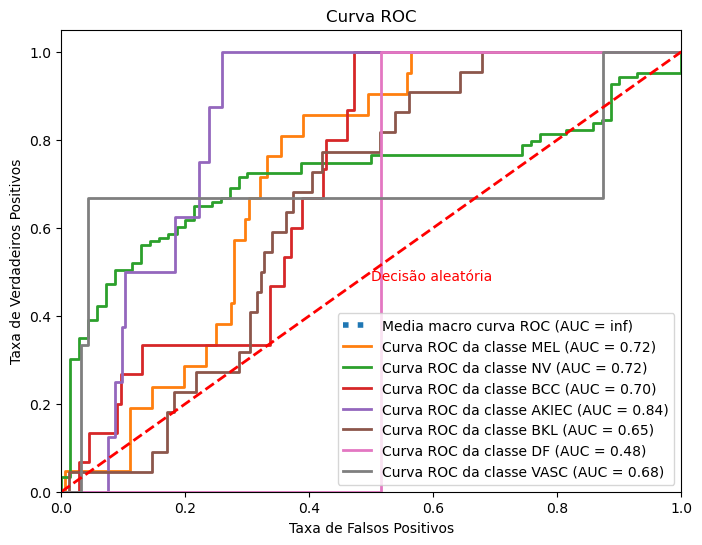

In [14]:
plt.figure(figsize=(8,6))

LABELS_MACRO = f"Media macro curva ROC (AUC = {roc_auc['macro']:.2f})"

plt.plot(fpr["macro"], tpr["macro"], label=LABELS_MACRO, linestyle=":", linewidth=4)

LABEL_CLASSES = {
    i: f"Curva ROC da classe {class_} (AUC = {roc_auc[i]:.2f})" 
    for i, class_ in enumerate(CLASSES)
}

for i, label in LABEL_CLASSES.items():
    plt.plot(fpr[i], tpr[i], lw=2, label=label)

plt.plot([0, 1], [0, 1], "k--",color="red", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.annotate("Decisão aleatória",(.5,.48),color="red")
plt.xlabel("Taxa de Falsos Positivos")
plt.ylabel("Taxa de Verdadeiros Positivos")
plt.title("Curva ROC")
plt.legend(loc="best")
plt.savefig("auc_roc.png")
plt.show()